# Aula 17 &mdash; Árvores de decisão

Renato Vimieiro

rv2 {em} cin.ufpe.br

maio 2017

In [2]:
import pandas as pd
import numpy as np
import graphviz as gviz
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
prostate = pd.read_csv("http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data",
                       header=0,index_col=0,sep='\t')
prostate['prognostico'] = prostate.gleason.map(lambda x: x >=7 and 'mau' or 'bom')
treino = prostate[prostate.train=='T'].drop('train',axis=1)
teste = prostate[prostate.train=='F'].drop('train',axis=1)

## Introdução

Nesta aula veremos como um ajustar um modelo baseado em árvores para o problema de aprendizado supervisionado. A ideia de ajustar árvores para apoiar a decisão é dividir o espaço de amostras de forma a obter um grupo mais homogêneo. Dessa forma, esperamos ter respostas mais acuradas tanto para o problema de classificação quanto para regressão.

Os modelos baseados em árvores são bastante populares muito em função da facilidade na análise do modelo. As árvores podem ser lidas inclusive por não especialistas, que podem verificar a explicação para atribuição de um determinado valor ou classe para uma amostra. Além disso, modelos aleatorizados como Random Forest se mostraram bastante eficazes com problemas de alta dimensionalidade. Isso torna tais modelos muito atrativos para áreas como classificação de texto e bioinformática.

A seguir veremos uma árvore de decisão para o conjunto de dados de câncer de próstata abordado nas últimas aulas. Cada nó da árvore divide o espaço de amostras em dois sub-espaços, os que satisfazem a condição, e os que não satisfazem.

In [76]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(min_samples_leaf=10,criterion='entropy')
attrs = ['lpsa','lcavol','lweight','lcp','lbph','svi']
model.fit(treino[attrs],treino.prognostico.map(lambda x: x=='mau' and 1 or 0))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

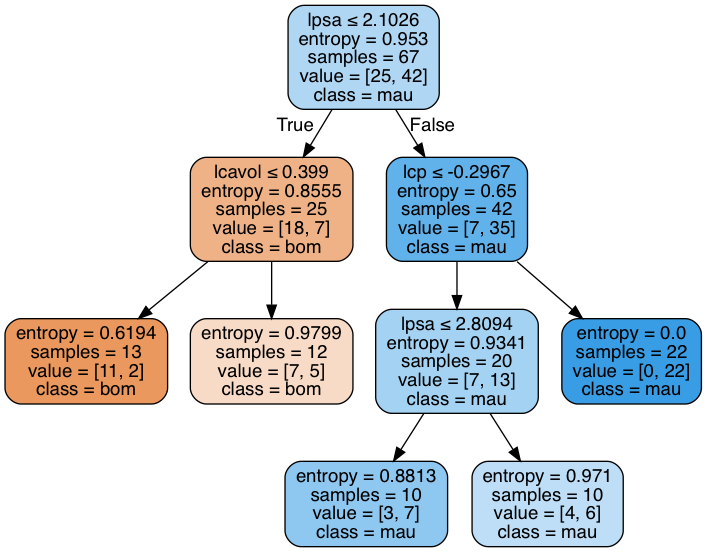

In [77]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(model, out_file=None, 
                         feature_names=attrs,  
                         class_names=['bom','mau'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
from io import StringIO
f = StringIO(dot_data)
g = gviz.Source(source=dot_data)
from IPython.display import Image
Image(g.pipe(format='png'),width='50%')

A raiz da árvore representa o espaço inteiro de amostras do problema. Como podemos ver, ela contém as 67 amostras do conjunto de treinamento.A condição imposta para dividir o espaço de busca é um limiar sobre o valor do PSA. As amostras que possuem PSA abaixo de 2.10 caem à esquerda, enquanto as demais à direita. Graficamente, a situação que observamos é a seguinte:

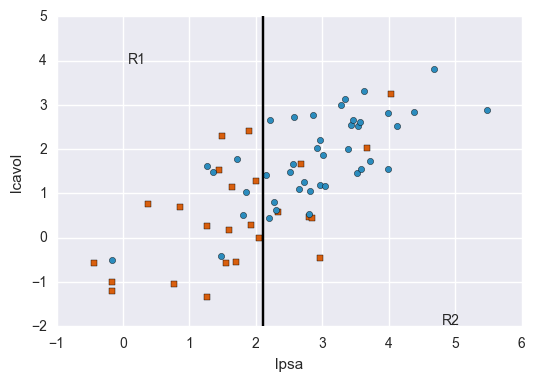

In [61]:
ax = treino.loc[treino.prognostico=='bom',['lcavol','lpsa']].plot.scatter(x='lpsa',
                                                                     y='lcavol',
                                                                     color='#d95f0e',
                                                                    marker='s')
treino.loc[treino.prognostico=='mau',['lcavol','lpsa']].plot.scatter(x='lpsa',
                                                                     y='lcavol',
                                                                     color='#2b8cbe',
                                                                    marker='o', ax=ax)
ax.axvline(2.1016,color='black')
ax.text(s='R1',x=0.08,y=3.95)
ax.text(s='R2',x=4.8, y=-1.95)

A divisão do espaço de amostras em dois sub-espaços fez com que as amostras de uma mesma região fossem mais homogêneas, isto é, eram majoritariamente da mesma classe. Como podemos perceber, de fato, à direita se concentraram majoritariamente as amostras da classe 'mau', enquanto que à esquerda estão da classe 'bom'.

O modelo continua a ser ajustado recursivamente em cada sub-espaço, buscando homogeneizar ainda mais as amostras. De fato, se observamos, o espaço *R1* pode ser subdividido próximo a 0.5 de forma que a maior parte dos maus fiquem na parte superior e as boas na parte inferior. O valor exato calculado pelo algoritmo na árvore acima foi 0.399. Logo, temos a divisão do espaço R1 em R3 e R4 como a seguir:

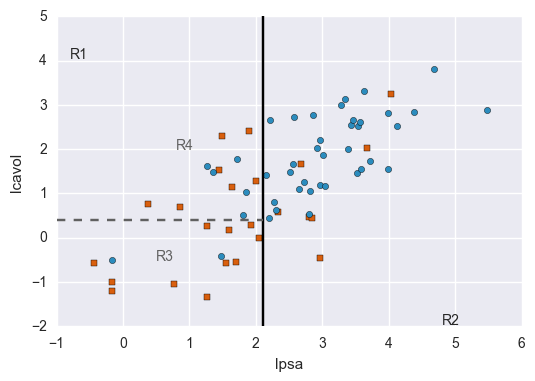

In [69]:
ax = treino.loc[treino.prognostico=='bom',['lcavol','lpsa']].plot.scatter(x='lpsa',
                                                                     y='lcavol',
                                                                     color='#d95f0e',
                                                                    marker='s')
treino.loc[treino.prognostico=='mau',['lcavol','lpsa']].plot.scatter(x='lpsa',
                                                                     y='lcavol',
                                                                     color='#2b8cbe',
                                                                    marker='o', ax=ax)
ax.axvline(2.1016,color='black')
ax.axhline(0.399,xmin=0,xmax=0.445,linestyle='--',color='#606060')
ax.text(s='R1',x=-0.8,y=4.05)
ax.text(s='R2',x=4.8, y=-1.95)
ax.text(s='R4',x=0.8,y=2,color='#606060')
ax.text(s='R3',x=0.5,y=-0.5,color='#606060')

Como podemos ver, o espaço R3 é quase inteiramente composto por amostra da classe 'bom'. Somente duas amostras, dentre 13, são maus. Assim, podemos dizer que uma amostra que cai nessa região do espaço de amostras tem aproximadamente 85% de chance de pertencer à classe bom.

O algoritmo procede recursivamente refinando cada novo sub-espaço gerado até que um critério de parada seja alcançado. Os dois critérios mais comuns para interromper o refinamento dos nós são: (1) número mínimo de amostras no nó; e (2) pureza do nó (dada como proporção da classe majoritária).

Além do critério de parada, outras perguntas que surgem nesse ponto são:

1. Como escolher o atributo para particionar o espaço de amostras?
2. Escolhido o atributo, como definir o ponto de corte desse atributo?

## Algoritmo

A construção da árvore de decisão é feita de forma gulosa. Isso porque avaliar todas as possibilidades de árvore para escolher a que resulta na melhor estrutura (mais acurada) é um problema computacionalmente complexo (exponencial). Dessa forma, em cada região (sub-espaço) de amostras, o atributo-valor que resulta na divisão mais homogênea (ou que melhora a divisão corrente) é escolhido.

Zaki e Meira Jr. (ver referências) apresentam o seguinte algoritmo:

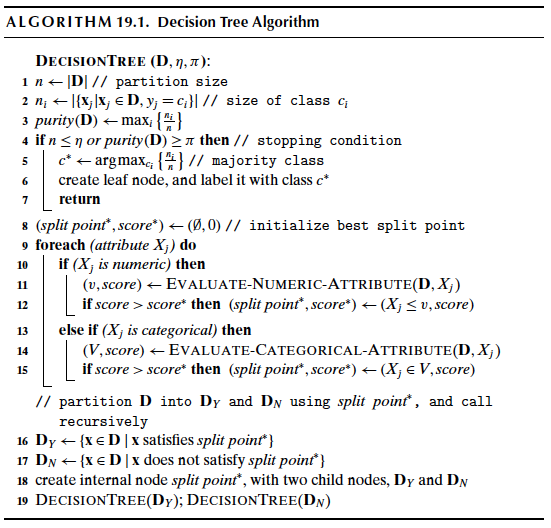

In [70]:
Image(filename='images/decisionTreeAlg.png')

O algoritmo basicamente avalia se os critérios de parada pureza ou número mínimo de amostras foram atingidos e, caso não tenham sido, procede com a avaliação gulosa dos atributos e, posteriormente, refinamento recursivo dos sub-espaços. Notem que o algoritmo funciona tanto com atributos categóricos quanto numéricos. Outra observação é que o algoritmo se baseia em alguma métrica para avaliar a qualidade do corte. Assim, nos resta investigar como obter um corte e avaliá-lo.

## Avaliando pontos de corte

As duas métricas mais usadas em árvores de decisão para avaliar a qualidade de um corte (pureza) são: entropia (ganho de informação); e índice de Gini.

#### Entropia e ganho de informação

A entropia é uma métrica da desorganização de um sistema. Nesse contexto, ela serve para avaliar a homogeneidade de uma região. Quanto mais diversa a região (mistura de amostras de várias classes), maior a desorganização do sistema, logo maior sua entropia. Do ponto de vista de [Teoria da Informação](https://en.wikipedia.org/wiki/Entropy_(information_theory)), a entropia expressa a quantidade de informação da variável (nesse caso a classe). Baixa entropia significa que a variável é pouco informativa, em outras palavras, se todas as amostras possuem a mesma classe, a variável não traz qualquer informação. Dessa forma, a métrica é bastante útil para a construção de árvores de decisão. Podemos avaliar o quanto a divisão do espaço de amostra usando um ponto de corte reduz da entropia atual da região, e escolhemos o que maximize essa redução. Tal redução é chamada de ganho de informação.

A entropia de uma região $R$ é formalmente definida por:

$$
H(R) = -\sum_{i=1}^{k}P(c_i~|~R)\log_2P(c_i~|~R)
$$

É fácil perceber que $H(R)$ é mínimo (zero) quando a região contém somente amostras de uma mesma classe. Igualmente, o valor é máximo ($\log_21/k$) quando a proporção de amostras de cada classe é a mesma ($P(c_i~|~R)=1/k$).

O ganho de informação é a diferença entre a entropia da região e o valor esperada da entropia para as regiões após a divisão no ponto de corte. Formalmente:

$$
IG(R,R_e,R_d) = H(R) - \left(\frac{n_e}{n}H(R_e) + \frac{n_d}{n}H(R_d)\right)
$$

Para exemplificar, vamos considerar a raiz da árvore do nosso exemplo. A entropia inicial (de todo o espaço de amostras) é:

In [74]:
p = treino.prognostico.value_counts()/treino.shape[0]
logp = np.log2(p)
ent = -np.sum(p*logp)
print(ent)

0.953048347158


Já as entropias das novas regiões definidas por $lpsa\leq 2.1026$ são 

In [73]:
nE = np.sum(treino.lpsa<=2.1026)
pE = treino[treino.lpsa<=2.1026].prognostico.value_counts()/nE
logpE = np.log2(pE)
entE = -np.sum(pE*logpE)

nD = np.sum(treino.lpsa>2.1026)
pD = treino[treino.lpsa>2.1026].prognostico.value_counts()/nD
logpD = np.log2(pD)
entD = -np.sum(pD*logpD)

print(entE,entD)

0.85545081056 0.650022421648


Agora podemos calcular o ganho de informação em particionar o espaço de amostras nesse ponto de corte

In [75]:
IG = ent - (nE/treino.shape[0])*entE - (nD/treino.shape[0])*entD
print(IG)

0.226373541587


A título de curiosidade, podemos comparar com outros pontos de corte. Por exemplo, podemos compará-lo com o corte que dividiu a região R1 no exemplo acima em R3 e R4

In [79]:
nE = np.sum(treino.lcavol<=0.399)
pE = treino[treino.lcavol<=0.399].prognostico.value_counts()/nE
logpE = np.log2(pE)
entE = -np.sum(pE*logpE)

nD = np.sum(treino.lcavol>0.399)
pD = treino[treino.lcavol>0.399].prognostico.value_counts()/nD
logpD = np.log2(pD)
entD = -np.sum(pD*logpD)

IG = ent - (nE/treino.shape[0])*entE - (nD/treino.shape[0])*entD
print(IG)

0.193639946253


Ou ainda com outro valor de PSA

In [80]:
nE = np.sum(treino.lpsa<=4)
pE = treino[treino.lpsa<=4].prognostico.value_counts()/nE
logpE = np.log2(pE)
entE = -np.sum(pE*logpE)

nD = np.sum(treino.lpsa>4)
pD = treino[treino.lpsa>4].prognostico.value_counts()/nD
logpD = np.log2(pD)
entD = -np.sum(pD*logpD)

IG = ent - (nE/treino.shape[0])*entE - (nD/treino.shape[0])*entD
print(IG)

0.00813094133337


O mesmo calculado pode ser usado com cortes baseados em variáveis categóricas. Por exemplo, baseado no atributo invasão da vesícula seminal.

In [81]:
nE = np.sum(treino.svi==0)
pE = treino[treino.svi==0].prognostico.value_counts()/nE
logpE = np.log2(pE)
entE = -np.sum(pE*logpE)

nD = np.sum(treino.svi!=0)
pD = treino[treino.svi!=0].prognostico.value_counts()/nD
logpD = np.log2(pD)
entD = -np.sum(pD*logpD)

IG = ent - (nE/treino.shape[0])*entE - (nD/treino.shape[0])*entD
print(IG)

0.177757331627


Notem que a escolha do par atributo-valor que otimiza o ganho de informação requer um esforço computacional bastante grande. Não é intenção desse curso entrar em detalhes sobre como obter tais valores eficientemente. O livro de Zaki e Meira Jr. abordam esse assunto de forma bastante intuitiva. Eu recomendo a leitura do capítulo 19 para quem tiver interesse nesses aspectos.

#### Índice de Gini

O índice de Gini avalia a desigualdade na distribuição da frequência de valores. A métrica é formalmente definida por:

$$
G(R) = \sum_{i=1}^kP(c_i~|~R)(1-P(c_i~|~R))
$$

O índice de Gini assume o menor valor (zero) quando a região possui somente amostras de uma classe. Em outras palavras, o índice de Gini é mínimo quando $P(c_i~|~R)\approx 1$ para alguma classe $c_i$. Assim, a medida também pode ser usada como métrica de pureza. 

Calculamos o valor esperado para o índice de Gini para avaliar uma partição. Quanto menor o índice, melhor é a partição.

$$
G(R_i,R_j) = \frac{n_i}{n}G(R_i) + \frac{n_j}{n}G(R_j)
$$

Vamos avaliar os mesmos cortes do exemplo usando o índice de Gini. Inicialmente calculamos o índice para todo o espaço de amostras.

In [84]:
p = treino.prognostico.value_counts()/treino.shape[0]
G = np.sum(p*(1-p))
print(G)

0.467810202718


Em seguida, calculamos para a partição $lpsa\leq 2.1026$.

In [85]:
nE = np.sum(treino.lpsa<=2.1026)
pE = treino[treino.lpsa<=2.1026].prognostico.value_counts()/nE
GE = np.sum(pE*(1-pE))

nD = np.sum(treino.lpsa>2.1026)
pD = treino[treino.lpsa>2.1026].prognostico.value_counts()/nD
GD = np.sum(pD*(1-pD))
G = (nE/treino.shape[0])*GE + (nD/treino.shape[0])*GD
print(G)

0.324577114428


Como vemos, a partição reduz o índice de Gini, indicando que o refinamento é benéfico.

Podemos compará-lo com outras partições.

In [86]:
nE = np.sum(treino.lcavol<=0.399)
pE = treino[treino.lcavol<=0.399].prognostico.value_counts()/nE
GE = np.sum(pE*(1-pE))

nD = np.sum(treino.lcavol>0.399)
pD = treino[treino.lcavol>0.399].prognostico.value_counts()/nD
GD = np.sum(pD*(1-pD))
G = (nE/treino.shape[0])*GE + (nD/treino.shape[0])*GD
print(G)

0.344047954299


In [87]:
nE = np.sum(treino.svi==0)
pE = treino[treino.svi==0].prognostico.value_counts()/nE
GE = np.sum(pE*(1-pE))

nD = np.sum(treino.svi!=0)
pD = treino[treino.svi!=0].prognostico.value_counts()/nD
GD = np.sum(pD*(1-pD))
G = (nE/treino.shape[0])*GE + (nD/treino.shape[0])*GD
print(G)

0.38748564868


## Árvores de decisão para regressão

Como disse, as árvores de decisão podem ser usadas tanto para classificação quanto para regressão. No caso de regressão, a intenção é particionar o espaço de amostras em sub-espaços ou regiões homogêneas de tal forma que o valor a ser predito para a variável dependente é a média dos valores da região. Isso implica que a forma de avaliação dos pontos de corte deve ser alterada.

Podemos usar no caso de regressão a soma dos quadrados dos resíduos, assim como fizemos para regressão linear. Definida por:

$$
RSS(R_i,R_j) = \sum_{v:x_v\in R_i}(y_v-\bar{y_{R_i}})^2 + \sum_{v:x_v\in R_j}(y_v-\bar{y_{R_j}})^2
$$

Ou ainda, podemos usar o ganho de informação baseado em entropia diferencial. Para os interessados, verificar [Criminisi et al. (2011)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/decisionForests_MSR_TR_2011_114.pdf).

## Ajustando árvores de decisão com sklearn

Como vimos no início desta aula, `sklearn` possui implementações de árvores de decisão tanto para classificação quanto para regressão. A sintaxe é similar ao que temos visto com os demais modelos. O modelo requer o conjunto de atributos e rótulos para ser ajustado. O modelo permite ainda a escolha do critério de avaliação ('gini' ou 'entropy'), e de outros parâmetros como número mínimo de amostras na folha e grau de pureza para interromper o refinamento.

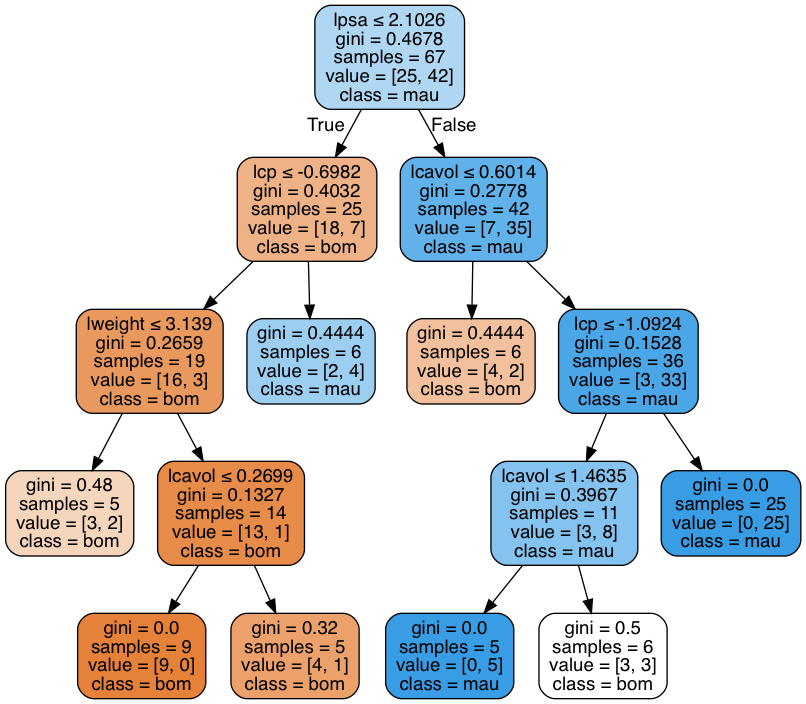

In [90]:
model = DecisionTreeClassifier(min_samples_leaf=5,criterion='gini')
attrs = ['lpsa','lcavol','lweight','lcp','lbph','svi']
model.fit(treino[attrs],treino.prognostico.map(lambda x: x=='mau' and 1 or 0))
dot_data = export_graphviz(model, out_file=None, 
                         feature_names=attrs,  
                         class_names=['bom','mau'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
f = StringIO(dot_data)
g = gviz.Source(source=dot_data)
Image(g.pipe(format='png'),width='60%')

In [91]:
pd.crosstab(model.predict(treino[attrs]),treino.prognostico)

prognostico,bom,mau
row_0,,
0,23,8
1,2,34


In [92]:
pd.crosstab(model.predict(teste[attrs]),teste.prognostico)

prognostico,bom,mau
row_0,,
0,9,4
1,1,16


## Bagging e Random Forest

Apesar de bastante intuitivo, um modelo baseado em árvore de decisão não está entre aqueles que possuem o melhor desempenho em termos de precisão/acurácia. O problema central de árvores de decisão é que elas possuem *alta variância*. Isso significa que, para dois conjuntos de treinamento distintos, amostrados da mesma população, os modelos ajustados nos dois conjuntos serão bastante distintos. Contudo, como discutimos na aula sobre Regressão Linear, se tivéssemos uma grande quantidade de conjuntos de treinamento e calculássemos a média (ou o voto majoritário) dos diversos modelos ajustados nesses dados, esse modelo 'médio' seria bem acurado para a população. 

A ideia central da técnica conhecida como *bagging* (Bootstrap aggregation) é simular esse comportamento. É verdade que não temos uma grande amostra de conjunto de treinamentos. No entanto, podemos criá-los a partir dos dados que possuímos. Geramos vários conjuntos de treinamento fazendo uma amostragem aleatória com reposição dos exemplos do conjunto de treinamento. Em seguida, treinamos vários modelos para cada conjunto. E nosso modelo final é a média (regressão) ou voto majoritário (classificação) dos múltiplos modelos ajustados. Como ajustamos modelos para vários conjuntos de dados, a variância total é reduzida e, consequentemente, temos um modelo mais 'confiável'. De fato essa técnica se mostra bastante útil na prática.

Outra técnica que usa aleatoriedade para aumentar a precisão do modelo é Random Forest. Nesse modelo, além de ajustar diversas árvores como fizemos com bagging, cada ponto de corte é avaliado somente para um subconjunto (pequeno, tipicamente $\sqrt{p}$) de atributos escolhidos aleatoriamente. Novamente, a saída do modelo é o voto majoritário para classificação ou a média dos valores para regressão. Random Forest tem se mostrado um dos classificadores mais acurados na prática. Ele é bastante útil, sobretudo com dados de alta dimensionalidade, uma vez que somente um pequeno subconjunto de atributos é avaliado em cada nó.

Finalmente, esses modelos podem ser usados ainda para avaliar a relevância dos atributos para predição da variável dependente. Podemos usar o RSS ou ganho de informação médio para ranquear os atributos. Aqueles com maior ganho de informação médio são os que melhor discriminam as amostras das diferentes classes.

In [119]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(min_samples_leaf=1,
                               criterion='gini',
                               n_estimators=1000)
attrs = ['lpsa','lcavol','lweight','lcp','lbph','svi']
model.fit(treino[attrs],treino.prognostico.map(lambda x: x=='mau' and 1 or 0))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [120]:
pd.crosstab(model.predict(treino[attrs]),treino.prognostico)

prognostico,bom,mau
row_0,,
0,25,0
1,0,42


In [121]:
pd.crosstab(model.predict(teste[attrs]),teste.prognostico)

prognostico,bom,mau
row_0,,
0,7,2
1,3,18


In [123]:
print(model.feature_importances_)
print(attrs)

[ 0.27565982  0.26201404  0.16674159  0.16987596  0.08304752  0.04266106]
['lpsa', 'lcavol', 'lweight', 'lcp', 'lbph', 'svi']
